In [23]:
import numpy as np
np.random.seed(0)
import pandas as pd
# from matplotlib import pyplot as plt
# % matplotlib inline
import platform
from scipy.io import loadmat
import pickle
import scipy as sc
import statsmodels.api as sm
from matplotlib import cm
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
from scipy import stats

import numpy.matlib
import matplotlib.patches as patches
from matplotlib import gridspec


# path = '../../../data/'
path = 'C:/Users/user/Aviel/Bias Project/project/Data/'
from utils_full import *

mgcv = importr('mgcv')
base = importr('base')
psyphy= importr('psyphy')
stats = importr('stats')
link = psyphy.probit_2asym(.05,.05)
fam = stats.binomial(link)


def mgcv_fit(df_,model,factors=False,newdata=[]):
    datar= base.data_frame(df_)
    if type(factors) == list:
        for fac in factors:
            datar[columns.index(fac)] = base.as_factor(datar[columns.index(fac)]) # declaring y1 into a factor
    b=mgcv.gam(ro.r(model),\
               data=datar,\
               family=fam,\
               optimizer='perf')

    if isinstance(newdata, pd.DataFrame):
        fs,es = mgcv.predict_gam(b,newdata=newdata,type="terms",se="True")
    else:
        fs,es = mgcv.predict_gam(b,type="terms",se="True")
    fs = np.asarray(fs)
    es = np.asarray(es)
    return [fs,es]


def mgcv_fit_bam(df_,model,factors=False,newdata=[]):
    datar= base.data_frame(df_)
    if type(factors) == list:
        for fac in factors:
            datar[columns.index(fac)] = base.as_factor(datar[columns.index(fac)]) # declaring y1 into a factor
    b=mgcv.bam(ro.r(model),\
               data=datar,\
               family=fam)
    if isinstance(newdata, pd.DataFrame):
        fs,es = mgcv.predict_bam(b,newdata=newdata,type="terms",se="True")
    else:
        fs,es = mgcv.predict_bam(b,type="terms",se="True")
    fs = np.asarray(fs)
    es = np.asarray(es)
    return [fs,es]


In [2]:
def build_features_math(data_dict,alphas=[]):
    
    f1 = data_dict['f1'] 
    f2 = data_dict['f2'] 
    Y = data_dict['resp'] 
    acc = data_dict['acc'] 
    maths = data_dict['math'].copy()
    
    try:
        cgroup = data_dict['cgroup'] 
    except: 
        cgroup = np.ones_like(f1)
        
    Ytrue = ((f1-f2)<0).astype(int) # what the subject should answer

    lag = 5
    Y1 = Y[:,lag-1:-1]
    d1 = f1[:,lag:]-f1[:,lag-1:-1]
    d12 = f1[:,lag:]-f2[:,lag-1:-1]
    d2 = f1[:,lag:]-f1[:,lag-2:-2]
    d3 = f1[:,lag:]-f1[:,lag-3:-3]
    d4 = f1[:,lag:]-f1[:,lag-4:-4]
    d5 = f1[:,lag:]-f1[:,lag-5:-5]
    # df = (f1-f2)[:,lag:]
    df = (f2-f1)[:,lag:]
    dinf = f1[:,lag:]-f1.mean()
    
    maths[maths==0] = 1
    maths[maths == 55] = 0
    pre_math = maths[:,lag-1:-1]
    pre_math2 = maths[:,lag-2:-2]
    pre_math3 = maths[:,lag-3:-3]
    pre_math4 = maths[:,lag-4:-4]
    pre_math5 = maths[:,lag-5:-5]
    
    
    if alphas == []:
        alphas = np.zeros_like(f1[:,1:])
    
    alp_tmp = np.zeros_like(f1[:,1:])
    for i in range(len(alp_tmp)):
        alp_tmp[i][maths[i][1:]==0] = alphas[i]
         
    alphas = alp_tmp[:,lag-1:]

    maths = maths[:,lag:]


    corr = (Y==Ytrue).astype(int) # whether subject responded correct or wrong
    corr1 = 2*(corr[:,lag-1:-1])-1 # correct or wrong
    corr =  2*(corr[:,lag:]).astype(int)-1 # correct
    Y  = Y[:,lag:]
    Ytrue1  = Ytrue[:,lag-1:-1]
    switch1 = corr1 * Y1 # correct * previous
    
    cgroup  = cgroup[:,lag:]

    dinf_g1 = np.copy(dinf)
    dinf_g2 = np.copy(dinf)
    dinf_g1[cgroup>0] = 0
    dinf_g2[cgroup<=0] = 0
    
    d1_g1 = np.copy(d1)
    d1_g2 = np.copy(d1)
    d1_g1[cgroup>0] = 0
    d1_g2[cgroup<=0] = 0
    
    side = np.copy(dinf)
    side[side<0] = -1
    side[side>0] = 1

    macc = np.copy(acc[:,lag:])
    for i_s in range(acc.shape[0]):
        macc[i_s,:] = acc[i_s,:].mean()
        
    thresh = .75
    group = (macc < thresh).astype(int)*2-1
    subject = np.tile(np.arange(Y.shape[0]),[Y.shape[1],1]).T
    
#     if alphas == []:
#         alphas = np.zeros_like(f1[:,1:])
        
#     alphas = alphas[:,lag-1:]

    trials = np.matlib.repmat(np.linspace(0,d1.shape[1]-1,d1.shape[1]),f1.shape[0],1)
    trials = trials*(macc.max()-macc.min())/trials.max() + macc.min()
    
    d1,d12,d1_g1,d1_g2,d2,d3,d4,d5,df,dinf,dinf_g1,dinf_g2,macc,alphas,trials,maths,pre_math,pre_math2,pre_math3,pre_math4,pre_math5,\
    Ytrue1,corr,corr1,switch1,group,side,cgroup,subject,Y,Y1 =\
    [u.reshape(1,-1) for u in [d1,d12,d1_g1,d1_g2,d2,d3,d4,d5,df,dinf,dinf_g1,dinf_g2,macc,alphas,trials,maths,pre_math,pre_math2,pre_math3,\
                               pre_math4,pre_math5,Ytrue1,corr,corr1,switch1,group,side,cgroup,subject,Y,Y1]]
    

    X = np.vstack( [df,d1,d12,d1_g1,d1_g2,d2,d3,d4,d5,dinf,dinf_g1,dinf_g2,macc,alphas,trials,pre_math,pre_math2,pre_math3,pre_math4,pre_math5,\
                    Ytrue1,corr,corr1,switch1,group,side,cgroup,subject,Y1])
    D = np.vstack([X,Y]).T
    D = D[np.where((maths==0)[0])[0],:]
    columns=['df','d1','d12','d1_g1','d1_g2','d2','d3','d4','d5','dinf','dinf_g1','dinf_g2','acc','alphas','trials','pre_math',\
             'pre_math2','pre_math3','pre_math4','pre_math5','ytrue1','corr','corr1','switch1','group','side','cgroup','subject','y1','y']
    df_ = pd.DataFrame(D,columns=columns)

    return df_, columns, data_dict


def build_features_subject_math(data_dict,subject):

    f1 = data_dict['f1'] 
    f2 = data_dict['f2']
    Y = data_dict['resp'] 
    acc = data_dict['acc'] 
    maths = data_dict['math'].copy()
    maths[maths==0] = 1
    maths[maths == 55] = 0

    lag = 1
    Y1 = Y[subject,lag-1:-1]
    Y  = Y[subject,lag:]
    d1 = f1[subject,lag:]-f1[subject,lag-1:-1]
    df = (f2-f1)[subject,lag:]
    dinf = f1[subject,lag:]-f1.mean()
    trials = np.linspace(0,f1.shape[1]-2,f1.shape[1]-1)+1
    mf = 0.5*(f1[subject,lag:]+f2[subject,lag:])
    mf = np.round(mf)
#     mf = (mf-mf.min())
#     mf = mf/mf.max()

    maths  = maths[subject,lag:]


    d1,df,dinf,trials,mf,Y =\
    [u.reshape(1,-1) for u in [d1,df,dinf,trials,mf,Y]]

    df[df==0] = 0.5
    Y[df==0] = 1 
        
    X = np.vstack( [df,d1,dinf,trials,mf])
    D = np.vstack([X,Y]).T
    D = D[np.where((maths==0))]
#     D = D[:149,:]

    columns=['df','d1','dinf','trials','mf','y']
    df_ = pd.DataFrame(D,columns=columns)
    return df_, columns, data_dict

def fit_alphas(data,infer='all'):
    ns,nt = data['f1'].shape
    dfs, datas = [],[]
    for i_sub in range(ns):
        df, columns, data = build_features_subject_math(data,i_sub)
        dfs.append(df)
        datas.append(data)
        
    mgcv = importr('mgcv')
    base = importr('base')
    psyphy= importr('psyphy')
    stats = importr('stats')
    link = psyphy.probit_2asym(.05,.05)
    fam = stats.binomial(link)

    if infer == 'all':
        model = 'y~s(trials,mf,by=df)'
    elif infer == 'trials':
        model = 'y~s(trials,by=df)'
    elif infer == 'mf':
        model = 'y~s(mf,by=df)'
    else:
        model = 'y~s(df)'


    A = []
    E = []
    for df in dfs:
        datar= base.data_frame(df)
        b=mgcv.gam(ro.r(model),\
                   data=datar,\
                   family=fam,\
                  optimizer='perf')

        fs,es = mgcv.predict_gam(b,type="terms",se="True")
        # se: standard error estimates
        A.append(np.asarray(fs))
        E.append(np.asarray(es))

    alphas = []
    for i in range(len(dfs)):
        alphas.append(np.squeeze(A[i])/dfs[i]['df'].values)
    alphas = np.array(alphas)
    return alphas

In [3]:
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
# import pandas.rpy.common as com
from rpy2.robjects.conversion import py2ri
from rpy2.robjects import pandas2ri
rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

In [4]:
# datasets_dict = pickle.load( open( path + "datasets.p", "rb", encoding = "utf-8" ) )

with open(path + "datasets.p", "rb") as f:
    datasets_dict = pickle.load(f, encoding="latin1")

fnames = ['passive_encoding_new']

dist_names = fnames
# dist_dict = {0:dist_names[0], 1:dist_names[1], 2:dist_names[2], 3:dist_names[3]}
# colors_dict = {0:'b',1:'r',2:'g',3:'c'}

key = 'various'

thresh = 0.0089138

dfs = []
datas = []
lims = [(.6,1.)]

for lim in lims:
    data = datasets_dict[key][fnames[0]].copy()
    
    data_dict,_ = filter_sub_trials_math(data,\
                      acc_lims_s = lim,\
                      acc_lims_m = (.85,1),
                      consistency_prm={'n_window': 10, 'w_window': 60, 'thresh': thresh},\
                      trial_lims = (0,600))
    
    alphas = fit_alphas(data_dict,infer='none')

    df, columns, data = build_features_math(data_dict,alphas)
    dfs.append(df)
    datas.append(data)


in log e
before filtering:  153
After acc filtering:  117
After consistency filtering:  117
total left:  117/153
total excluded:  36/153
included: 76.4 % ; excluded: 23.5 %


C:\Users\user\miniconda3\envs\py39\lib\site-packages\ipykernel_launcher.py:187: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\user\miniconda3\envs\py39\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [5]:
# print(data_dict.keys())

# print(data_dict['f1'])

# print(data_dict['f1'].shape)

# B = np.arange(data_dict['f1'].shape[0])
# print(B)

# for k,v in data_dict.items():
#     data_dict[k] = v[B,:]
#     print(data_dict[k])
#     print(v)

# for k,v in data_dict.items(): 
#         try:
#             data_dict[k] = v[Is_sub,:]

In [6]:
df.shape

print(type(df))

print(type(dfs))


print(type(dfs[0]))

data

<class 'pandas.core.frame.DataFrame'>
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


{'acc': array([[1., 1., 1., ..., 1., 1., 1.],
        [0., 1., 1., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 0., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 'resp': array([[0., 0., 1., ..., 1., 0., 0.],
        [0., 1., 0., ..., 1., 1., 1.],
        [0., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 1., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 1.],
        [1., 1., 0., ..., 1., 1., 0.]]),
 'gender': array([[array(['male'], dtype='<U4'), array(['male'], dtype='<U4'),
         array(['male'], dtype='<U4'), ..., array(['male'], dtype='<U4'),
         array(['male'], dtype='<U4'), array(['male'], dtype='<U4')],
        [array(['female'], dtype='<U6'), array(['female'], dtype='<U6'),
         array(['female'], dtype='<U6'), ...,
         array(['female'], dtype='<U6'), array(['female'], dtype='<U6'),
         array(['female'], dtype='<U6')],
        [array(['male'], dtype

In [7]:
print(117*300)
print(dfs)

35100
[             df        d1       d12  d1_g1     d1_g2        d2        d3  \
0     -0.043611  0.060311 -0.045804    0.0  0.060311 -0.639985 -0.803771   
1     -0.105056  0.636535  0.680146    0.0  0.636535  0.696846 -0.003450   
2     -0.066416 -0.862811 -0.757754    0.0 -0.862811 -0.226276 -0.165964   
3      0.127063 -0.048228 -0.174912    0.0 -0.048228  0.035164 -0.827646   
4     -0.025829  0.160357  0.033294    0.0  0.160357  0.112129  0.195521   
...         ...       ...       ...    ...       ...       ...       ...   
17245 -0.017959 -0.016268  0.004469    0.0 -0.016268 -0.471550 -0.579001   
17246  0.076908 -0.483049 -0.465090    0.0 -0.483049 -0.499317 -0.954599   
17247  0.117516  0.026775 -0.050133    0.0  0.026775 -0.456275 -0.472543   
17248  0.033119 -0.037206 -0.154723    0.0 -0.037206 -0.010432 -0.493481   
17249 -0.064567  0.609187  0.576068    0.0  0.609187  0.571981  0.598755   

             d4        d5      dinf  ...  ytrue1  corr  corr1  switch1  group  \

In [8]:
df_1 = df[df['pre_math']==0].copy()
print(df_1)
df_1 = df_1.set_index(np.arange(len(df_1)))
print(df_1)

             df        d1       d12  d1_g1     d1_g2        d2        d3  \
0     -0.043611  0.060311 -0.045804    0.0  0.060311 -0.639985 -0.803771   
1     -0.105056  0.636535  0.680146    0.0  0.636535  0.696846 -0.003450   
2     -0.066416 -0.862811 -0.757754    0.0 -0.862811 -0.226276 -0.165964   
4     -0.025829  0.160357  0.033294    0.0  0.160357  0.112129  0.195521   
5     -0.047552  0.570875  0.596704    0.0  0.570875  0.731232  0.683004   
...         ...       ...       ...    ...       ...       ...       ...   
17245 -0.017959 -0.016268  0.004469    0.0 -0.016268 -0.471550 -0.579001   
17246  0.076908 -0.483049 -0.465090    0.0 -0.483049 -0.499317 -0.954599   
17247  0.117516  0.026775 -0.050133    0.0  0.026775 -0.456275 -0.472543   
17248  0.033119 -0.037206 -0.154723    0.0 -0.037206 -0.010432 -0.493481   
17249 -0.064567  0.609187  0.576068    0.0  0.609187  0.571981  0.598755   

             d4        d5      dinf  ...  ytrue1  corr  corr1  switch1  group  \
0     

In [9]:
df_2 = df[df['pre_math']==1].copy()
print(df_2)
df_2 = df_2.set_index(np.arange(len(df_2)))
print(df_2)

             df        d1       d12  d1_g1     d1_g2        d2        d3  \
3      0.127063 -0.048228 -0.174912    0.0 -0.048228  0.035164 -0.827646   
9      0.133695 -0.563580 -0.617936    0.0 -0.563580 -0.320108 -0.681706   
10    -0.132170 -0.049341 -0.009683    0.0 -0.049341 -0.258710  0.168105   
11     0.101625 -0.237039 -0.184783    0.0 -0.237039 -0.186753 -1.039771   
13     0.111950 -0.800797 -0.813883    0.0 -0.800797 -0.328022 -0.933613   
...         ...       ...       ...    ...       ...       ...       ...   
17235 -0.034259  0.450043  0.331241    0.0  0.450043  0.728979  0.164067   
17238  0.015819 -0.135043 -0.261177    0.0 -0.135043  0.428354  0.305322   
17239 -0.127948 -0.083040 -0.096066    0.0 -0.083040  0.461599  0.326556   
17240  0.116527  0.274916  0.405461    0.0  0.274916 -0.098220 -0.393256   
17242 -0.006986  0.878790  0.963623    0.0  0.878790  0.959745  0.607540   

             d4        d5      dinf  ...  ytrue1  corr  corr1  switch1  group  \
3     

In [10]:
mgcv = importr('mgcv')
base = importr('base')
psyphy= importr('psyphy')
stats = importr('stats')
link = psyphy.probit_2asym(.05,.05)
fam = stats.binomial(link)

A = []
E = []

model = 'y~s(alphas,by=df) + s(d1,k=4) +s(dinf,k=7)'

model = 'y~ s(alphas,by=df,k=5) + s(d1,k=4) + s(dinf,k=7) \
    + s(subject,bs="re")+ s(d1,subject,bs="re") + s(dinf,subject,bs="re")'

for i,df in enumerate([df_1,df_2]): 
    print(i)

    try:
        fs,es = mgcv_fit_bam(df,model,factors=['subject'])
    except:
        fs,es = mgcv_fit(df,model,factors=['subject'])

    A.append(fs)
    E.append(es)


0
1


In [11]:
print(len(A))
print(A[0].shape)
print(E[0].shape)

print(len(E))
print(A[1].shape)
print(E[1].shape)


2
(8639, 6)
(8639, 6)
2
(8611, 6)
(8611, 6)


In [12]:
dict_ = {'A':A,'E':E}
pickle.dump( dict_, open( "passive_active.p", "wb" ) )

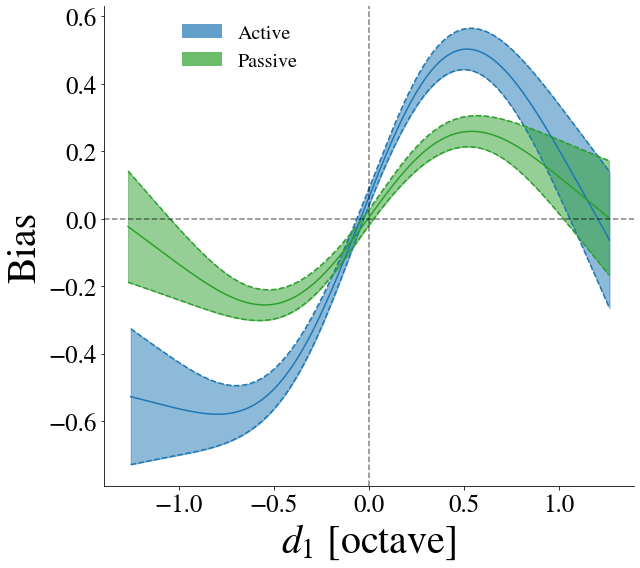

In [77]:
from matplotlib.patches import Rectangle


f ,ax = plt.subplots(1,figsize=(9,8),sharey='row',sharex=True)
colors = ['blue','green','cornflowerblue','lightgreen','red','m']
colors = ['blue','green']
colors = ['tab:blue','tab:green']
alpha=.5

# Chaning font to stix
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


for i,df in enumerate([df_1,df_2]): 
    fs,es = A[i],E[i]
    
    o = np.argsort(df['d1'].values)
    plot_with_errors(ax,df['d1'].values[o],fs[o,1],es[o,1],color=colors[i],alpha=alpha)
    ax.set_xlabel('$d_1$ [octave]',fontsize=40)
    ax.set_ylabel('Bias',fontsize=40) 
    
    simpleaxis(ax,25)

p1 = Rectangle((0, 0), 1, 1, fc='tab:blue', alpha=.7)
p2 = Rectangle((0, 0), 1, 1, fc='tab:green', alpha=.7)


ax.legend([p1, p2], ['Active','Passive'],
          bbox_to_anchor=(0.4, 1),ncol= 1,
          fontsize=20,
          frameon=False)


# specifying horizontal line type at y=0
plt.axhline(y = 0, color = 'k', alpha = 0.5, linestyle = '--')
# specifying vertical line type at y=0
plt.axvline(x=0, color = 'k', alpha = 0.5, linestyle = '--')


plt.tight_layout()

plt.show()


In [15]:
# # f, ax = plt.subplots(1,figsize=[8,8],sharey=True)

# res_len = len(A)

# lens = []
# lens.append(len(A[0]))

# noise = 0
# y = np.arange(res_len)

# print(y)

# bplot1 = ax.boxplot(A, 1, positions=y, vert=1, patch_artist=True, showmeans=True, widths = 0.2, showfliers=False)




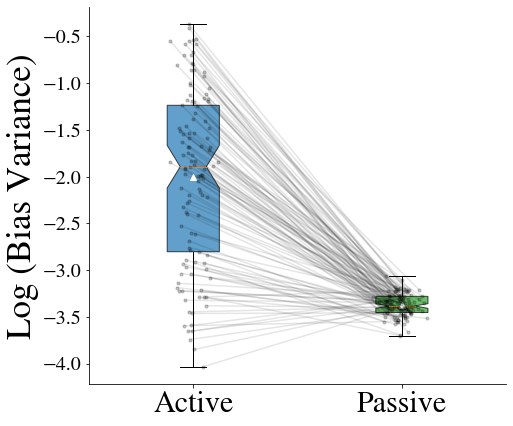

In [78]:
def plot_boxscatter(res,xlabel='',ylabel='',title='',color_var=[]):
    f,ax = plt.subplots(1,figsize=[7,6],sharey=True)
    
    # Chaning font to stix
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'

    res_len = len(res)
    
    lens = []
    lens.append(len(res[0]))

    noise = 0
    y = np.arange(res_len)
    
    bplot1 = ax.boxplot(res,1, positions=y,vert=1,patch_artist=True,showmeans=True, \
                        meanprops={"markerfacecolor":"w", "markeredgecolor":"w"}, \
                        widths = 0.25,showfliers=True)
    
    # fill with colors
    colors = ['tab:blue','tab:green']
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    noise = []
    ys = []
    for i in range(res_len):
        ys.append(np.ones_like(res[i])*y[i] + np.random.randn(len(res[i]))*.05)
                
        # ys.append(np.ones_like(res[i])*y[i])
        # noise.append(np.random.randn(len(res[i]))*.07)

    ax.plot(ys,res,'-',color='k',alpha=.1)

    # for patch,c in zip(bplot1['boxes'],['yellow','gold','lightblue','dodgerblue']):
    #     patch.set_facecolor(c)
    
    cm = plt.cm.get_cmap('jet_r')
    for i in range(res_len):
        # sc = ax.scatter(ys[i],res[i],alpha=1,c=color_var, zorder=10, vmin=.55, vmax=1,cmap=cm,s=30)
        sc = ax.scatter(ys[i],res[i],alpha=0.2,c='k', zorder=10, vmin=.55, vmax=1,cmap=cm,s=10)
    
    # if color_var!=[]:
    #     plt.colorbar(sc)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    ax.set_xticks(np.arange(res_len))
    ax.set_ylabel(ylabel,fontsize=35)

    simpleaxis(ax,20)
    ax.set_xticklabels(xlabel,rotation=0,fontsize=30)
    ax.set_title(title,fontsize=35)
    
    plt.tight_layout(pad=1)

    plt.show()
    
res = []
res.append([])
fs = A[0]
for p in range(int(df_1['subject'].max()+1)):
    o = (df_1['subject'].values==p)
    res[-1].append((fs[o,1]+fs[o,4]).var())

res.append([])
fs = A[1]
for p in range(int(df_2['subject'].max()+1)):
    o = (df_2['subject'].values==p)
    res[-1].append((fs[o,1]+fs[o,4]).var())


res = [np.log(r) for r in res]
# plot_boxscatter(res,\
#                 xlabel=['Active','Passive'],\
#                 ylabel='Log (Bias Variance)',\
#                 title='Bias')

plot_boxscatter(res,\
                xlabel=['Active','Passive'],\
                ylabel='Log (Bias Variance)')

In [59]:
from scipy.stats import wilcoxon

print(wilcoxon(res[0], res[1]))

WilcoxonResult(statistic=123.0, pvalue=1.3925817713118905e-19)


In [73]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(res[0], res[1])
print(U1,p)

12472.0 1.6383570470721768e-27


#### Differences of difference 

In [72]:
diff_var = []

diff_var.append(res[0] - res[1])

In [ ]:
from scipy import stats

dunn = importr('dunn.test')


for param, param_name in zip([diff_var, diff_area, diff_slope], ['Variance', 'Area', 'Slope']):
    print('=========================================')
    print(param_name)
    print('============KRUSKAL===============')
    print(stats.kruskal(*param))
    k = dunn.dunn_test(param, method="bonferroni")
    print('============DUNN===============')
    print(k)